Hamiltonian (H_heis3):
[[ 2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  2.+0.j -2.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  2.+0.j  0.+0.j -2.+0.j  2.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  2.+0.j]]


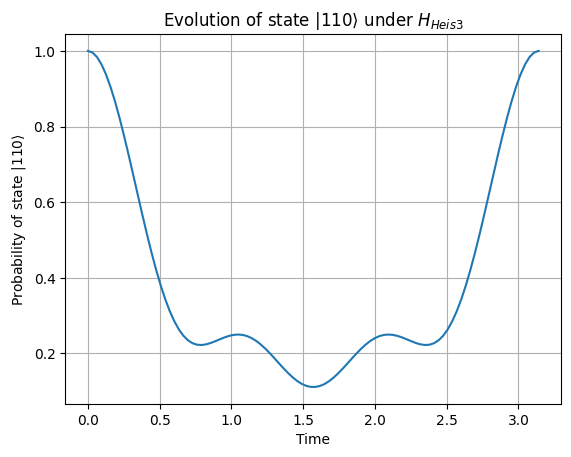

/var/folders/sh/0h8ntjj94y998dvtjqqsg2500000gn/T/ipykernel_20513/1036891460.py:154: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(session=session)


AttributeError: 'PrimitiveResult' object has no attribute 'quasi_dists'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Session
from qiskit.quantum_info import SparsePauliOp

# Define basis states
Zero = np.array([[1], [0]])
One = np.array([[0], [1]])

def tensor_prod(*args):
    """
    Compute the tensor product of multiple matrices.
    """
    result = np.array([[1]])
    for matrix in args:
        result = np.kron(result, matrix)
    return result

def H_heis3():
    # Define Pauli matrices
    I = np.eye(2)
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])
    
    # Calculate the Hamiltonian terms
    XXs = tensor_prod(I, X, X) + tensor_prod(X, X, I)
    YYs = tensor_prod(I, Y, Y) + tensor_prod(Y, Y, I)
    ZZs = tensor_prod(I, Z, Z) + tensor_prod(Z, Z, I)
    
    # Sum the terms to get the Hamiltonian
    H = XXs + YYs + ZZs
    
    return H

def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multiplied by time t multiplied by the 3 spin XXX Heisenberg Hamiltonian 
    return expm(-1j * t * H)

# Print the Hamiltonian matrix for verification
print("Hamiltonian (H_heis3):")
print(H_heis3())

# Define array of time points
ts = np.linspace(0, np.pi, 100)

# Define initial state |110>
initial_state = tensor_prod(One, One, Zero)

# Compute probability of remaining in |110| state over the array of time points
probs_110 = [np.abs(initial_state.conj().T @ U_heis3(t) @ initial_state)[0, 0]**2 for t in ts]

# Plot evolution of |110|
plt.plot(ts, probs_110)
plt.xlabel('Time')
plt.ylabel(r'Probability of state $|110\rangle$')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
plt.grid()
plt.show()

# Parameterize variable t to be evaluated at t=pi later
t = Parameter('t')

# Build a subcircuit for XX(t) two-qubit gate
XX_qr = QuantumRegister(2)
XX_qc = QuantumCircuit(XX_qr, name='XX')

XX_qc.ry(np.pi/2, [0, 1])
XX_qc.cx(0, 1)
XX_qc.rz(2 * t, 1)
XX_qc.cx(0, 1)
XX_qc.ry(-np.pi/2, [0, 1])

# Convert custom quantum circuit into a gate
XX = XX_qc.to_instruction()

# Build a subcircuit for YY(t) two-qubit gate
YY_qr = QuantumRegister(2)
YY_qc = QuantumCircuit(YY_qr, name='YY')

YY_qc.rx(np.pi/2, [0, 1])
YY_qc.cx(0, 1)
YY_qc.rz(2 * t, 1)
YY_qc.cx(0, 1)
YY_qc.rx(-np.pi/2, [0, 1])

# Convert custom quantum circuit into a gate
YY = YY_qc.to_instruction()

# Build a subcircuit for ZZ(t) two-qubit gate
ZZ_qr = QuantumRegister(2)
ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')

ZZ_qc.cx(0, 1)
ZZ_qc.rz(2 * t, 1)
ZZ_qc.cx(0, 1)

# Convert custom quantum circuit into a gate
ZZ = ZZ_qc.to_instruction()

# Combine subcircuits into a single multiqubit gate representing a single trotter step
num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

for i in range(0, num_qubits - 1):
    Trot_qc.append(ZZ, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i+1]])

# Convert custom quantum circuit into a gate
Trot_gate = Trot_qc.to_instruction()

# Use Aer's simulator

# Create a Quantum Circuit to measure the Trotter step
qc = QuantumCircuit(Trot_qr)
qc.append(Trot_gate, Trot_qr)

# Add measurement
qc.measure_all()

# Bind the parameter t to pi using assign_parameters
qc_bound = qc.assign_parameters({t: np.pi})

# Define the number of qubits for the observable
n = 3

# Define the single Pauli terms as ("Paulis", [indices], coefficient)
interactions = [("ZZ", [i, i + 1], 1) for i in range(n - 1)]  # we assume spins on a 1D line
field = [("X", [i], -1) for i in range(n)]

# Build the operator
hamiltonian = SparsePauliOp.from_sparse_list(interactions + field, num_qubits=n)

# Transpile for IBM Quantum backend
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=n)

transpiled_qc = transpile(qc_bound, backend=backend)

# Run on IBM Quantum backend
with Session(service=service, backend=backend) as session:
    sampler = Sampler(session=session)
    job = sampler.run([transpiled_qc])
    result = job.result()

counts = result.quasi_dists[0].binary_probabilities()
print("Measurement counts (real quantum computer):", counts)

# Plot the measurement results from the real quantum computer
plot_histogram(counts)
plt.show()
